In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-21T15:09:38.073052+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
from catboost import CatBoostRegressor, Pool, cv

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

sklearn   : 0.24.2
seaborn   : 0.11.1
numpy     : 1.20.3
matplotlib: 3.3.4
pandas    : 0.25.3



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [8]:
NTRY = 25
NAME = f'{NTRY}_cb_pca64_sber_bord_nose_iter_2mod'

In [9]:
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [10]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [11]:
df_train.shape, df_test.shape, 

((6981, 292), (3000, 289))

In [12]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [13]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend(['dow', 
                 'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', #'distrib_brdr',
                 #'spec_event_1',
                ])

In [14]:
for el in cat_cols:
    df_train[el] = df_train[el].astype(str)
    df_test[el] = df_test[el].astype(str)

In [15]:
#views
train_views_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                         df_train[df_train.distrib_brdr == 1][['views']],
                         cat_features = cat_cols,
                         #feature_names = cat_cols + num_cols
                        )
train_views_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 0][['views']],
                       cat_features = cat_cols,
                       #feature_names = cat_cols + num_cols
                      )
#depth
train_depth_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                         df_train[df_train.distrib_brdr == 1][['depth']],
                         cat_features = cat_cols,
                         #feature_names = cat_cols + num_cols
                        )
train_depth_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 0][['depth']],
                       cat_features = cat_cols,
                       #feature_names = cat_cols + num_cols
                      )

#frp
train_frp_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 1][['full_reads_percent']],
                       cat_features = cat_cols,
                       #feature_names = cat_cols + num_cols
                      )
train_frp_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                     df_train[df_train.distrib_brdr == 0][['full_reads_percent']],
                     cat_features = cat_cols,
                     #feature_names = cat_cols + num_cols
                    )

#full_reads_percent
#у frp корреляция с depth. так что добавим признак deprh_pred и соберем датасет уже после предсказания depth

In [16]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [17]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

In [18]:
cb_params_views = {"iterations": 2500,
                  #"depth": 2,
                  "loss_function": "RMSE",
                  'eval_metric': 'R2',
                  "verbose": False
                  }

In [19]:
def get_model(inp_pool, inp_params):
    
    
    scores = cv(inp_pool,
                      inp_params,
                      fold_count=5,
                      seed = CB_RANDOMSEED, 
                      #plot="True"
                     )
    
    #if scores['test-RMSE-mean'].argmin() != scores['test-R2-mean'].argmax():
    #    raise ValueError('wtf?', scores['test-RMSE-mean'].argmin(), scores['test-R2-mean'].argmax())
    
    print(scores[scores['test-R2-mean'] == scores['test-R2-mean'].max()].to_string())
    
    niters = scores['test-R2-mean'].argmax()
    print(niters)
    
    cb_model = CatBoostRegressor(iterations=niters,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 #n_estimators=100,
                                  )
    # Fit model
    cb_model.fit(inp_pool,
                      #plot = True,
                       verbose = 100,
                      )
    
    
    return cb_model

In [20]:
#scores_views

In [21]:
%%time
model_views_start = get_model(train_views_start, cb_params_views)

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
2410        2410      0.514488     0.085848       0.996769      0.000571    57288.439777   21396.965895      4719.273203      150.040884
2410
Learning rate set to 0.02457
0:	learn: 83167.4254994	total: 30.4ms	remaining: 1m 13s
100:	learn: 53574.6758291	total: 3.31s	remaining: 1m 15s
200:	learn: 43912.6562626	total: 6.72s	remaining: 1m 13s
300:	learn: 38721.1823427	total: 10.2s	remaining: 1m 11s
400:	learn: 34440.9100319	total: 13.5s	remaining: 1m 7s
500:	learn: 30710.4857723	total: 16.9s	remaining: 1m 4s
600:	learn: 27579.1810837	total: 20.2s	remaining: 1m
700:	learn: 25294.2672771	total: 23.7s	remaining: 57.7s
800:	learn: 23110.9294598	total: 27.4s	remaining: 55s
900:	learn: 21272.7214876	total: 31s	remaining: 51.8s
1000:	learn: 19575.0531380	total: 34.3s	remaining: 48.3s
1100:	learn: 18143.7007650	total: 37.8s	remaining: 44.9s
1200:	learn: 16852.416

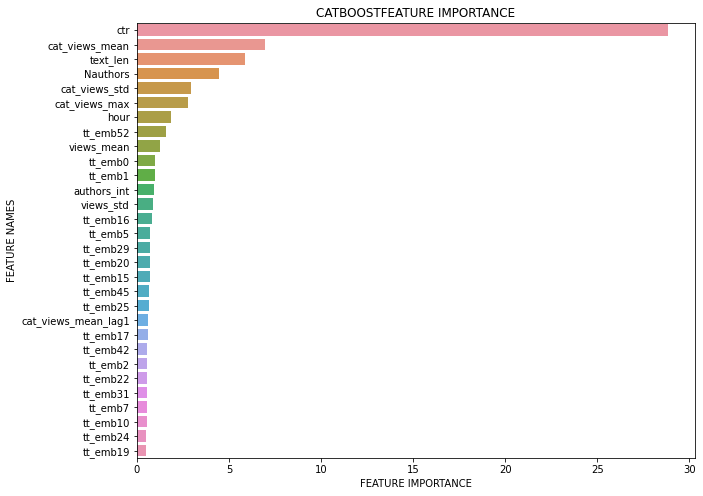

In [22]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_views_start.get_feature_importance(), train_views_start.get_feature_names(), 'CATBOOST')

In [ ]:
%%time
model_views_end = get_model(train_views_end, cb_params_views)

In [ ]:
plot_feature_importance(model_views_end.get_feature_importance(), train_views_end.get_feature_names(), 'CATBOOST')

## depth

In [ ]:
cb_params_depth = cb_params_views

In [ ]:
%%time
model_depth_start = get_model(train_depth_start, cb_params_depth)

In [ ]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_depth_start.get_feature_importance(), train_depth_start.get_feature_names(), 'CATBOOST')

In [ ]:
%%time
model_depth_end = get_model(train_depth_end, cb_params_depth)

In [ ]:
plot_feature_importance(model_depth_end.get_feature_importance(), train_depth_end.get_feature_names(), 'CATBOOST')

## full_reads_percent

In [ ]:
cb_params_frp = cb_params_views

In [ ]:
%%time
model_frp_start = get_model(train_frp_start, cb_params_frp)

In [ ]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_frp_start.get_feature_importance(), train_frp_start.get_feature_names(), 'CATBOOST')

In [ ]:
%%time
model_frp_end = get_model(train_frp_end, cb_params_frp)

In [ ]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_frp_end.get_feature_importance(), train_frp_end.get_feature_names(), 'CATBOOST')

## Сохраняем предсказания для ансамблей / стекинга

In [ ]:
pred_train = pd.DataFrame()
pred_train[['document_id', 'distrib_brdr']] = df_train[['document_id', 'distrib_brdr']]
pred_train = pred_train.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [ ]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.views.isna())

In [ ]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.depth.isna())

In [ ]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.full_reads_percent.isna())

In [ ]:
pred_train.drop(['distrib_brdr'], axis =1, inplace = True)
pred_train.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)

## save models

In [ ]:
#cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_pca64_cb_views.cbm'), 
model_views_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_views_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_depth_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_depth_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_frp_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_frp_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## make predict

In [ ]:
subm = pd.DataFrame()
subm[['document_id', 'distrib_brdr']] = df_test[['document_id', 'distrib_brdr']]
subm = subm.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [ ]:
subm.loc[subm.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.views.isna())

In [ ]:
subm.loc[subm.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.depth.isna())

In [ ]:
subm.loc[subm.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.full_reads_percent.isna())

In [ ]:
subm.drop(['distrib_brdr'], axis = 1, inplace = True)

In [ ]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

In [ ]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

In [ ]:
subm.head()

In [ ]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)